## chap20 전이학습을 통한 딥러닝의 성능 극대화

### 1 .  소규모 데이터셋으로 만드는 강력한 학습모델

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout,\
                                    Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import numpy as np
import matplotlib.pyplot as plt

In [4]:
#  기존의 이미지의 갯수를 늘리는 작업 : 데이터 전처리
train_datagen = ImageDataGenerator(rescale=1./255,   #  정규화
                  horizontal_flip=True,              # 수평으로 뒤집기
                  width_shift_range=0.1,             # 수평이동
                  height_shift_range=0.1,            # 수직이동
                  fill_mode='nearest')               # 빈 공간 채우는 방법
# train_datagen = ImageDataGenerator(rescale=1./255)

train_genarator = train_datagen.flow_from_directory(
                './data-ch20/train',           # 학습셋이 있는 폴더의 위치
                target_size=(150,150),
                batch_size=5,
                class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)  # 테스트셋은 정규화만
test_generator = test_datagen.flow_from_directory(
                './data-ch20/test',           # 학습셋이 있는 폴더의 위치
                target_size=(150,150),
                batch_size=5,
                class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [5]:
# CNN 모델 적용
model = Sequential()
model.add(Conv2D(32, kernel_size=3, input_shape=(150,150,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)       

In [6]:
# 컴파일 옵션 설정
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.0002),
             metrics=['accuracy'])

# 조기 중단 설정
early_stopping = EarlyStopping(patience=5)

# 모델 실행
history = model.fit(train_genarator, epochs=200, validation_data=test_generator,
                   validation_steps=10, callbacks=[early_stopping])

Epoch 1/200
32/32 [==============================] - 5s 103ms/step - loss: 0.7074 - accuracy: 0.4563 - val_loss: 0.6900 - val_accuracy: 0.5400
Epoch 2/200
32/32 [==============================] - 2s 68ms/step - loss: 0.6947 - accuracy: 0.4938 - val_loss: 0.6896 - val_accuracy: 0.5000
Epoch 3/200
32/32 [==============================] - 2s 68ms/step - loss: 0.6868 - accuracy: 0.5813 - val_loss: 0.6761 - val_accuracy: 0.6200
Epoch 4/200
32/32 [==============================] - 2s 71ms/step - loss: 0.6785 - accuracy: 0.6062 - val_loss: 0.6880 - val_accuracy: 0.3800
Epoch 5/200
32/32 [==============================] - 2s 69ms/step - loss: 0.6457 - accuracy: 0.6438 - val_loss: 0.6244 - val_accuracy: 0.7800
Epoch 6/200
32/32 [==============================] - 2s 74ms/step - loss: 0.6617 - accuracy: 0.6000 - val_loss: 0.6310 - val_accuracy: 0.5200
Epoch 7/200
32/32 [==============================] - 3s 82ms/step - loss: 0.6182 - accuracy: 0.6313 - val_loss: 0.5514 - val_accuracy: 0.6400
Epoch

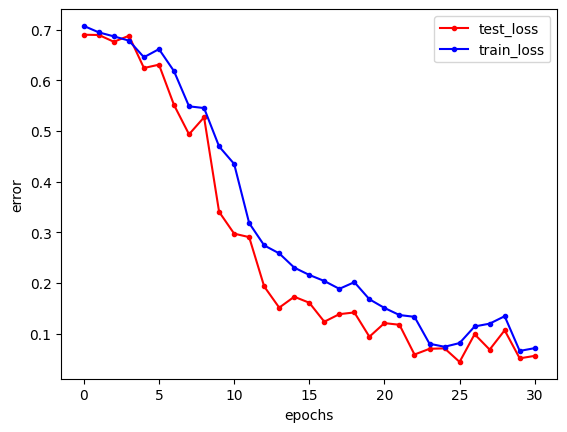

In [7]:
# 검증셋과 학습셋의 오차를 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

#  그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='test_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('error')

plt.show()

## 2. 전이학습으로 모델 성능 극대화

In [12]:
# VGG16 모델을 활용
from tensorflow.keras.applications import VGG16

# train_generator, test_generator 사용

# 모델 생성
# VGG16 모델 불러옴
trans_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
trans_model.trainable = False

trans_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [13]:
# 학습할 모델 생성
model = Sequential()
model.add(trans_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                524352    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 15,239,105
Trainable params: 524,417
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
# 컴파일 옵션 설정
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.0002),
             metrics=['accuracy'])

# 조기 중단 설정
early_stopping = EarlyStopping(patience=5)

# 모델 실행
history = model.fit(train_genarator, epochs=200, validation_data=test_generator,
                   validation_steps=10, callbacks=[early_stopping])

Epoch 1/200
32/32 [==============================] - 10s 266ms/step - loss: 0.7213 - accuracy: 0.5813 - val_loss: 0.4896 - val_accuracy: 0.8800
Epoch 2/200
32/32 [==============================] - 11s 333ms/step - loss: 0.5501 - accuracy: 0.7312 - val_loss: 0.4616 - val_accuracy: 0.8000
Epoch 3/200
32/32 [==============================] - 12s 364ms/step - loss: 0.4712 - accuracy: 0.8062 - val_loss: 0.4557 - val_accuracy: 0.8800
Epoch 4/200
32/32 [==============================] - 12s 362ms/step - loss: 0.3987 - accuracy: 0.8313 - val_loss: 0.4188 - val_accuracy: 0.8600
Epoch 5/200
32/32 [==============================] - 12s 363ms/step - loss: 0.3423 - accuracy: 0.8687 - val_loss: 0.3191 - val_accuracy: 0.9000
Epoch 6/200
32/32 [==============================] - 11s 358ms/step - loss: 0.3379 - accuracy: 0.8875 - val_loss: 0.2938 - val_accuracy: 0.9000
Epoch 7/200
32/32 [==============================] - 12s 361ms/step - loss: 0.3238 - accuracy: 0.8938 - val_loss: 0.3538 - val_accuracy:

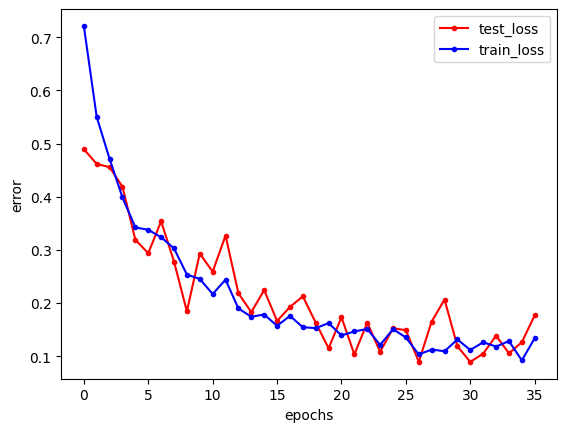

In [18]:
# VGG16 을 활용
# 검증셋과 학습셋의 오차를 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

#  그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='test_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('error')

plt.show()

In [16]:
from tensorflow.keras.applications import InceptionV3

trans_model = InceptionV3(input_shape=(150,150,3),
                      include_top=False)
trans_model.trainable = False
trans_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_100 (Conv2D)            (None, 74, 74, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_100[0][0]']             
 ormalization)                                                                                    
                                                                                       

In [17]:
# 학습할 모델 생성
model = Sequential()
model.add(trans_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [19]:
# 컴파일 옵션 설정
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.0002),
             metrics=['accuracy'])

# 조기 중단 설정
early_stopping = EarlyStopping(patience=5)

# 모델 실행
history = model.fit(train_genarator, epochs=200, validation_data=test_generator,
                   validation_steps=10, callbacks=[early_stopping])

Epoch 1/200
32/32 [==============================] - 9s 131ms/step - loss: 1.1890 - accuracy: 0.6938 - val_loss: 0.3488 - val_accuracy: 0.8800
Epoch 2/200
32/32 [==============================] - 3s 91ms/step - loss: 0.3680 - accuracy: 0.8687 - val_loss: 0.3097 - val_accuracy: 0.9000
Epoch 3/200
32/32 [==============================] - 3s 90ms/step - loss: 0.3131 - accuracy: 0.9000 - val_loss: 0.1942 - val_accuracy: 0.9000
Epoch 4/200
32/32 [==============================] - 3s 100ms/step - loss: 0.2283 - accuracy: 0.9125 - val_loss: 0.2157 - val_accuracy: 0.9200
Epoch 5/200
32/32 [==============================] - 4s 115ms/step - loss: 0.3061 - accuracy: 0.9000 - val_loss: 0.2567 - val_accuracy: 0.9000
Epoch 6/200
32/32 [==============================] - 4s 113ms/step - loss: 0.3211 - accuracy: 0.8750 - val_loss: 0.1381 - val_accuracy: 0.9200
Epoch 7/200
32/32 [==============================] - 4s 114ms/step - loss: 0.2160 - accuracy: 0.9000 - val_loss: 0.1424 - val_accuracy: 0.9400
E

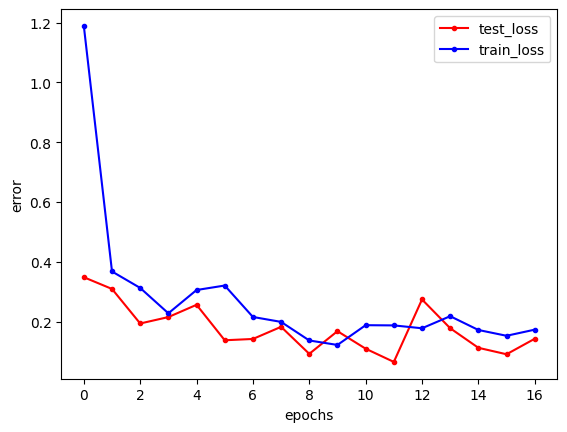

In [20]:
# InceptionV3
# 검증셋과 학습셋의 오차를 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

#  그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='test_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('error')

plt.show()